# Import et fonctions utilitaires

In [1]:
from PC import PC
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bn_vs_bn
import time
import itertools
import random
import matplotlib.pyplot as plt

#Fonction qui permet la création de tous les BN possible étant donné un graphe essentiel
def get_approxBN(bn,AlgoPC:PC):
    """
    - Si PC rend un graphe mixte ( un graphe essentiel, i.e. classe d'équivalence de markov ): construit une liste de BN possible
    - Si PC rend un DAG : construit le BN avec la même structure

    Parameters
    ----------
    AlgoPC : PC
        l'objet associé à l'apprentissage

    Returns
    -------
    liste de pyAgrum.BayesNet ou un pyAgrum.BayesNet
        le/les BN associé
    """
    nb_BN=2**len(AlgoPC.G.edges()) #le nombre de BN possible dépend du nombre d'arrete dans la classe d'équivalent de Markov
    bn_approx_base=gum.BayesNet('bn_approx_base')
    allApproxBn=[]
    for nodeID in AlgoPC.G.nodes():
        bn_approx_base.add(gum.LabelizedVariable(bn.variable(nodeID).name(),''))
    for (node1,node2) in AlgoPC.G.arcs():
        try :
            bn_approx_base.addArc(bn.variable(node1).name(),bn.variable(node2).name())
        except:
            #gnb.sideBySide(AlgoPC.G)
            return []
    if(len(AlgoPC.G.edges())!=0): #Si G a des arêtes
        allApproxBn=[gum.BayesNet(bn_approx_base) for _ in range(nb_BN)]
        permutations=[]
        for node1,node2 in AlgoPC.G.edges():
            permutations+=list(itertools.permutations((node1,node2))) 
        combinations=list(itertools.combinations(permutations,len(AlgoPC.G.edges())))
        l=[]
        for comb in combinations:
            hasRemoved=False
            for i in range(0,len(comb)-1):
                for j in range(i+1,len(comb)):
                    if( set(comb[i])==set(comb[j])):
                        l.append(comb)
                        hasRemoved=True
                        break
                if(hasRemoved):
                    break
        for comb in l:
            combinations.remove(comb)
        for (bn_i,comb) in zip(allApproxBn,combinations):
            for node1,node2 in comb:
                try:
                    bn_i.addArc(bn.variable(node1).name(),bn.variable(node2).name())
                except:
                    bn_i.addArc(bn.variable(node2).name(),bn.variable(node1).name())
    else : #Si G est un DAG
        allApproxBn.append(bn_approx_base)
    return allApproxBn
#Fonction qui permet la création d'un des BN possible étant donné un graphe essentiel
def getOneApproxBN(bn,AlgoPC:PC):
    bn_approx=gum.BayesNet('bn_approx_base')
    for nodeID in AlgoPC.G.nodes():
        bn_approx.add(gum.LabelizedVariable(bn.variable(nodeID).name(),''))
    for (node1,node2) in AlgoPC.G.arcs():
        bn_approx.addArc(bn.variable(node1).name(),bn.variable(node2).name())
    for node1,node2 in AlgoPC.G.edges():
        try:
            bn_approx.addArc(bn.variable(node1).name(),bn.variable(node2).name())
        except:
            bn_approx.addArc(bn.variable(node2).name(),bn.variable(node1).name())
    return bn_approx

** pyAgrum** For better visualizations, please install matplotlib-inline.


# 1. Algorithme PC

In [2]:
#Générer un BN aléatoire
def genRandomBN(n=20000,n_nodes=5, n_arcs=8, n_modmax=4,name_out="test.csv"):
    generator=gum.BNGenerator()
    bn=generator.generate(n_nodes, n_arcs, n_modmax)
    gum.generateCSV(bn,name_out, n, show_progress=False, with_labels=False)
    return bn

#Fonction d'apprentissage avec PC, retourne tous les BN issus du graphe essentiel
def learn_PC(bn,csvFilePath="test.csv",verbose=False):
    """Approxime un BN à partir de particules données à travers un CSV donné.

    Parameters
    ----------
    csvFilePath : str, optional
        chemin vers le fichier CSV, by default "test.csv"
    verbose : bool, optional
        Permet d'afficher le graphe mixte au cours de l'apprentissage et le BN approximé à la fin avec le BN utilisé pour générer les particules, by default False

    Returns
    -------
    pyAgrum.BayesNet
        Une approximation du BN qui a généré les particules
    """
    start=time.time()
    AlgoPC=PC(csvFilePath=csvFilePath)
    if verbose:
        GNonOriente=gum.MixedGraph(AlgoPC.G)
    AlgoPC.phase1()
    if verbose:
        GPhase1=gum.MixedGraph(AlgoPC.G)
    AlgoPC.phase2()
    end=time.time()
    duration=end-start
    all_bnApprox=get_approxBN(bn,AlgoPC)
    if verbose:
        GPhase2=gum.MixedGraph(AlgoPC.G)
        s='s' if duration>1 else ""
        print(f"Apprentissage en {duration} seconde{s} avec {AlgoPC.learner.nbRows()} particules généré à partir d'un BN avec {len(bn.nodes())} noeuds, {len(bn.arcs())} arcs et de modalité maximum {bn.maxVarDomainSize()} ")
        print("Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2")
        gnb.sideBySide(GNonOriente,GPhase1,GPhase2)
        print("1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC")
        gnb.sideBySide(bn,*all_bnApprox)
    return all_bnApprox,duration,AlgoPC

## 1.1 Exemple d'utilisation

In [12]:
############Exemple############
bn=genRandomBN()
bn_approx,duration,_=learn_PC(bn,csvFilePath="test.csv",verbose=True)

Apprentissage en 0.03126978874206543 seconde avec 20000 particules généré à partir d'un BN avec 5 noeuds, 5 arcs et de modalité maximum 3 
Graphe 1 : non orienté complet ------ Graphe 2 : après phase 1 ------ Graphe 3 : après phase 2


no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 3 --> 3 3 <!-- 0->3 --> 0->3 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 1->3 --> 1->3 <!-- 1->4 --> 1->4 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 2 --> 2 2 <!-- 1->2 --> 1->2 <!-- 2->4 --> 2->4 <!-- 3 --> 3 3 <!-- 3->4 --> 3->4,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 1->0 --> 1->0 <!-- 2 --> 2 2 <!-- 1->2 --> 1->2 <!-- 4 --> 4 4 <!-- 2->4 --> 2->4 <!-- 3 --> 3 3 <!-- 3->4 --> 3->4 <!-- 4->0 --> 4->0


1er BN = BN utilisé pour générer les particules ------ à partie du 2ème BN = Tous les BN possibles d'après l'algorithme PC


G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_1 --> n_1 n_1 <!-- n_0 --> n_0 n_0 <!-- n_1->n_0 --> n_1->n_0 <!-- n_2 --> n_2 n_2 <!-- n_2->n_1 --> n_2->n_1 <!-- n_2->n_4 --> n_2->n_4 <!-- n_4->n_0 --> n_4->n_0,G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_1 --> n_1 n_1 <!-- n_2 --> n_2 n_2 <!-- n_1->n_2 --> n_1->n_2 <!-- n_0 --> n_0 n_0 <!-- n_1->n_0 --> n_1->n_0 <!-- n_2->n_4 --> n_2->n_4 <!-- n_4->n_0 --> n_4->n_0,G <!-- n_3 --> n_3 n_3 <!-- n_4 --> n_4 n_4 <!-- n_3->n_4 --> n_3->n_4 <!-- n_1 --> n_1 n_1 <!-- n_0 --> n_0 n_0 <!-- n_1->n_0 --> n_1->n_0 <!-- n_2 --> n_2 n_2 <!-- n_2->n_1 --> n_2->n_1 <!-- n_2->n_4 --> n_2->n_4 <!-- n_4->n_0 --> n_4->n_0


## 1.2Analyse Expérimentale de PC

### 1.2.1 Test du temps d'execution moyen pour des BN en fonction du nombre de particules dans le CSV
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

In [22]:
#On teste l'algorithme quand le nombre de particules est de 1000, 5000, 10000, 15000 ou 20000
list_nb_particules=[1000,5000,10000,15000,20000]
#On fait 100 expériences pour chaque nombre de particules
nb_apprentissage_par_n=100

criteres_all=[]
#Pour chaque nombre de particules
for n in list_nb_particules:
    #Génerer le nombre de noeuds/arcs aléatoirement entre 5 et 10
    n_nodes=random.randint(5,10)
    n_arcs=int(n_nodes*1.25)
    #Génerer le BN aléatoirement et le CSV
    bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
    #On créer un nombre nb_apprentissage_par_n de BN
    for _ in range(nb_apprentissage_par_n):
        #Appel de PC
        _,duration,_=learn_PC(bn,csvFilePath="test.csv",verbose=False)
        criteres=dict()
        criteres["duration"]=duration
        criteres["nb_particule"]=n
        criteres_all.append(criteres)
#Calcul du temps moyen pour chaque nombre de particules 
bnx=[criteres["nb_particule"] for criteres in criteres_all]
bny=[criteres["duration"] for criteres in criteres_all]
list_moy_selon_nb_particules=[]
for n in list_nb_particules:
    moy=0
    i=0
    for criteres in criteres_all:
        if(criteres["nb_particule"]==n):
            moy+=criteres["duration"]
            i+=1
    list_moy_selon_nb_particules.append(moy/i)

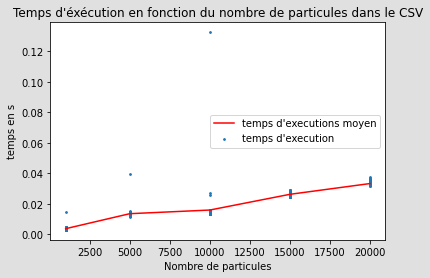

In [23]:
#Plot nombre particules/ Temps en s d'execution
scat=plt.scatter(bnx,bny,label="temps d'execution",s=3)
line=plt.plot(list_nb_particules,list_moy_selon_nb_particules,c='r',label="temps d'executions moyen")
plt.title("Temps d'éxécution en fonction du nombre de particules dans le CSV")
plt.xlabel("Nombre de particules")
plt.ylabel("temps en s")
plt.legend()
plt.show()

### 1.2.2 Test du temps d'execution moyen pour des BN en fonction du nombre noeuds dans le BN
- CSV = 5000 particules
- nb_arcs=1.25*nb_noeuds

In [54]:
nb_apprentissage_par_n_nodes=100
criteres_all=[]
list_nb_nodes=[5,10,15,20,25]
n=5000

for n_nodes in list_nb_nodes:
    n_arcs=int(1.25*n_nodes)
    bn=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
    for _ in range(nb_apprentissage_par_n_nodes):
        criteres=dict()
        _,duration,_=learn_PC(bn,csvFilePath="test.csv",verbose=False)
        criteres_all.append(criteres)
        criteres["duration"]=duration
        criteres["n_nodes"]=n_nodes
bnx=[criteres["n_nodes"] for criteres in criteres_all]
bny=[criteres["duration"] for criteres in criteres_all]
list_moy_selon_nb_nodes=[]
for n in list_nb_nodes:
    moy=0
    i=0
    for criteres in criteres_all:
        if(criteres["n_nodes"]==n):
            moy+=criteres["duration"]
            i+=1
    list_moy_selon_nb_nodes.append(moy/i)

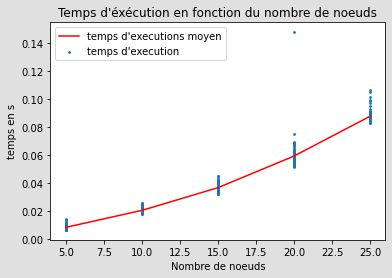

In [55]:
#Plot nombre particules/ Temps en s d'execution
scat=plt.scatter(bnx,bny,label="temps d'execution",s=3)
line=plt.plot(list_nb_nodes,list_moy_selon_nb_nodes,c='r',label="temps d'executions moyen")
plt.title("Temps d'éxécution en fonction du nombre de noeuds")
plt.xlabel("Nombre de noeuds")
plt.ylabel("temps en s")
plt.legend()
plt.show()

### 1.2.3 Test Structural Hamming, F-score, dist2opt en fonction du nombre de noeuds dans un BN
- CSV = 5000 particules

In [63]:
nb_apprentissage_par_n_nodes=100
criteres_all=[]
list_nb_nodes=[5,10,15,20,25]
n=5000

for n_nodes in list_nb_nodes:
    n_arcs=int(1.25*n_nodes)
    bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
    for _ in range(nb_apprentissage_par_n_nodes):
        bn_approx_all,duration,_=learn_PC(bn_original,csvFilePath="test.csv",verbose=False)
        bn_approx=random.choice(bn_approx_all)
        comparator=bn_vs_bn.GraphicalBNComparator(bn_original,bn_approx)
        #criteres=comparator.skeletonScores()
        criteres=comparator.scores()
        criteres.update(comparator.hamming())
        criteres["n_nodes"]=n_nodes
        criteres_all.append(criteres)

bnx=[criteres["n_nodes"] for criteres in criteres_all]
bny_hamming=[criteres["hamming"] for criteres in criteres_all]
bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
bny_precision=[criteres["precision"] for criteres in criteres_all]
bny_recall=[criteres["recall"] for criteres in criteres_all]
bny_fscore=[criteres["fscore"] for criteres in criteres_all]
bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

moy_all=dict()
for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
    list_moy_selon_nb_nodes=[]
    for n in list_nb_nodes:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["n_nodes"]==n):
                moy+=criteres[name]
                i+=1
        list_moy_selon_nb_nodes.append(moy/i)
    moy_all[name]=list_moy_selon_nb_nodes
        
    

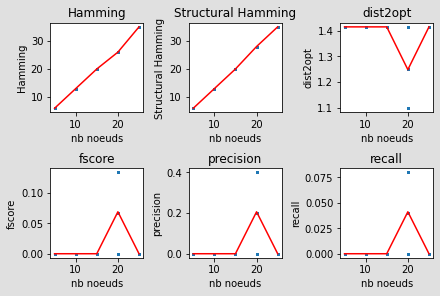

In [73]:
fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming",s=3)
f1_axes[0][0].set_title("Hamming")
f1_axes[0][0].plot(list_nb_nodes,moy_all["hamming"],c='r',label="Hamming moyen")
f1_axes[0][0].set_xlabel("nb noeuds")
f1_axes[0][0].set_ylabel("Hamming")

f1_axes[0][1].scatter(bnx,bny_StructuralHamming,label="Structural Hamming",s=3)
f1_axes[0][1].set_title("Structural Hamming")
f1_axes[0][1].plot(list_nb_nodes,moy_all["structural hamming"],c='r',label="Structural Hamming moyen")
f1_axes[0][1].set_xlabel("nb noeuds")
f1_axes[0][1].set_ylabel("Structural Hamming")

f1_axes[0][2].scatter(bnx,bny_dist2opt,label="dist2opt",s=3)
f1_axes[0][2].set_title("dist2opt")
f1_axes[0][2].plot(list_nb_nodes,moy_all["dist2opt"],c='r',label="dist2opt moyen")
f1_axes[0][2].set_xlabel("nb noeuds")
f1_axes[0][2].set_ylabel("dist2opt")

f1_axes[1][0].scatter(bnx,bny_fscore,label="fscore",s=3)
f1_axes[1][0].set_title("fscore")
f1_axes[1][0].plot(list_nb_nodes,moy_all["fscore"],c='r',label="fscore moyen")
f1_axes[1][0].set_xlabel("nb noeuds")
f1_axes[1][0].set_ylabel("fscore")

f1_axes[1][1].scatter(bnx,bny_precision,label="precision",s=3)
f1_axes[1][1].set_title("precision")
f1_axes[1][1].plot(list_nb_nodes,moy_all["precision"],c='r',label="precision moyen")
f1_axes[1][1].set_xlabel("nb noeuds")
f1_axes[1][1].set_ylabel("precision")

f1_axes[1][2].scatter(bnx,bny_recall,label="recall",s=3)
f1_axes[1][2].set_title("recall")
f1_axes[1][2].plot(list_nb_nodes,moy_all["recall"],c='r',label="recall moyen")
f1_axes[1][2].set_xlabel("nb noeuds")
f1_axes[1][2].set_ylabel("recall")

plt.show()


### 1.2.3 Test Structural Hamming, F-score, dist2opt en fonction du nombre de particules
- nb_noeuds = entier entre 5 et 10
- nb_arcs=1.25*nb_noeuds

In [6]:
nb_apprentissage_par_n_particules=100
criteres_all=[]
list_nb_particules=[1000,5000,10000,15000,20000]
for n in list_nb_particules:
    n_nodes=random.randint(5,10)
    n_arcs=int(1.25*n_nodes)
    bn_original=genRandomBN(n,n_nodes, n_arcs, n_modmax=4,name_out="test.csv")
    for _ in range(nb_apprentissage_par_n_particules):
        bn_approx_all,duration,_=learn_PC(bn_original,csvFilePath="test.csv",verbose=False)
        if len(bn_approx_all)==0:
            continue
        bn_approx=random.choice(bn_approx_all)
        comparator=bn_vs_bn.GraphicalBNComparator(bn_original,bn_approx)
        #criteres=comparator.skeletonScores()
        criteres=comparator.scores()
        criteres.update(comparator.hamming())
        criteres["nb_particules"]=n
        criteres_all.append(criteres)

bnx=[criteres["nb_particules"] for criteres in criteres_all]
bny_hamming=[criteres["hamming"] for criteres in criteres_all]
bny_StructuralHamming=[criteres["structural hamming"] for criteres in criteres_all]
bny_precision=[criteres["precision"] for criteres in criteres_all]
bny_recall=[criteres["recall"] for criteres in criteres_all]
bny_fscore=[criteres["fscore"] for criteres in criteres_all]
bny_dist2opt=[criteres["dist2opt"] for criteres in criteres_all]

moy_all=dict()
for name in ["hamming","structural hamming","precision","recall","fscore","dist2opt"]:
    list_moy_selon_nb_particules=[]
    for n in list_nb_particules:
        moy=0
        i=0
        for criteres in criteres_all:
            if(criteres["nb_particules"]==n):
                moy+=criteres[name]
                i+=1
        list_moy_selon_nb_particules.append(moy/i)
    moy_all[name]=list_moy_selon_nb_particules

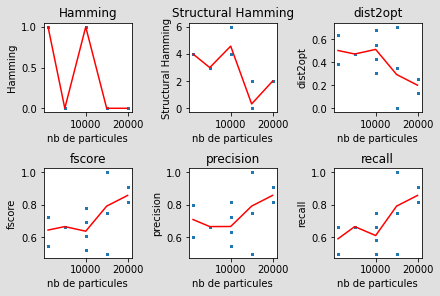

In [8]:
fig1, f1_axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True)
f1_axes[0][0].scatter(bnx,bny_hamming,label="Hamming",s=3)
f1_axes[0][0].set_title("Hamming")
f1_axes[0][0].plot(list_nb_particules,moy_all["hamming"],c='r',label="Hamming moyen")
f1_axes[0][0].set_xlabel("nb de particules")
f1_axes[0][0].set_ylabel("Hamming")

f1_axes[0][1].scatter(bnx,bny_StructuralHamming,label="Structural Hamming",s=3)
f1_axes[0][1].set_title("Structural Hamming")
f1_axes[0][1].plot(list_nb_particules,moy_all["structural hamming"],c='r',label="Structural Hamming moyen")
f1_axes[0][1].set_xlabel("nb de particules")
f1_axes[0][1].set_ylabel("Structural Hamming")

f1_axes[0][2].scatter(bnx,bny_dist2opt,label="dist2opt",s=3)
f1_axes[0][2].set_title("dist2opt")
f1_axes[0][2].plot(list_nb_particules,moy_all["dist2opt"],c='r',label="dist2opt moyen")
f1_axes[0][2].set_xlabel("nb de particules")
f1_axes[0][2].set_ylabel("dist2opt")

f1_axes[1][0].scatter(bnx,bny_fscore,label="fscore",s=3)
f1_axes[1][0].set_title("fscore")
f1_axes[1][0].plot(list_nb_particules,moy_all["fscore"],c='r',label="fscore moyen")
f1_axes[1][0].set_xlabel("nb de particules")
f1_axes[1][0].set_ylabel("fscore")

f1_axes[1][1].scatter(bnx,bny_precision,label="precision",s=3)
f1_axes[1][1].set_title("precision")
f1_axes[1][1].plot(list_nb_particules,moy_all["precision"],c='r',label="precision moyen")
f1_axes[1][1].set_xlabel("nb de particules")
f1_axes[1][1].set_ylabel("precision")

f1_axes[1][2].scatter(bnx,bny_recall,label="recall",s=3)
f1_axes[1][2].set_title("recall")
f1_axes[1][2].plot(list_nb_particules,moy_all["recall"],c='r',label="recall moyen")
f1_axes[1][2].set_xlabel("nb de particules")
f1_axes[1][2].set_ylabel("recall")

plt.show()

# Algorithme PC-Stable

## Analyse Expérimentale de PC-Stable

# Conclusion

# Bonus ?